In [8]:
from numba import vectorize, cuda
import numpy as np

The following attriutes will be used in this Section!
- cuda.device_array
- cuda.copy_to_host()
- cuda.to_device()

###### Managing GPU Memory

During the benchmarking in the previous notebook, we used NumPy arrays on the CPU as inputs and outputs. If you want to reduce the impact of host-to-device/device-to-host bandwidth, <b>it is best to copy data to the GPU explicitly</b> and leave it there to amortize the cost over multiple function calls. In addition, allocating device memory can be relatively slow, so <b> allocating GPU arrays once and refilling them with data from the host can also be a performance improvement. </b>

Let's create our example addition ufunc again:

###### Simple function

In [9]:
@vectorize(['float32(float32, float32)'], target='cuda') # ???
def add_ufunc(x, y):
    return x + y

In [10]:
n = 100000
x = np.arange(n).astype(np.float32)
y = 2 * x

In [11]:
%timeit add_ufunc(x, y)  # Baseline performance with host arrays

2.58 ms ± 595 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
len(cuda.gpus)

1

In [14]:
cuda.gpus[0].name

b'GeForce GTX 1050 Ti'

<b>The numba.cuda module includes a function that will copy host data to the GPU and return a CUDA device array:</b>

In [19]:
x_device = cuda.to_device(x)
y_device = cuda.to_device(y)

print(x_device)
print(x_device.shape)
print(x_device.dtype)

(100000,)
float32


Device arrays can be passed to CUDA functions just like NumPy arrays, but without the copy overhead:

In [29]:
%timeit add_ufunc(x_device, y_device) # it is faster corresponding to the first case

829 µs ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


That's a big performance improvement already, but we are <b>still allocating a device array for the output of the ufunc and copying it back to the host</b>. We can create the output buffer with the numba.cuda.device_array() function:

In [30]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)  # does not initialize the contents, like np.empty()

In [32]:
%timeit add_ufunc(x_device, y_device, out=out_device)

688 µs ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now that we <b>have removed the device allocation and copy steps</b>, the computation runs much faster than before. When we want to bring the device array back to the host memory, we can use the <b>copy_to_host()</b> method

In [43]:
out_host = out_device.copy_to_host()
print(out_host[:10])
print(out_host.shape)

[ 0.  3.  6.  9. 12. 15. 18. 21. 24. 27.]
(100000,)


In [59]:
print(out_device[:10]) # How to watch it?
print(out_device.shape)

(100000,)


##### Exercise

In [60]:
import math

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def make_pulses(i, period, amplitude):
    return max(math.sin(i / period) - 0.3, 0.0) * amplitude

n = 100000
noise = (np.random.normal(size=n) * 3).astype(np.float32)
t = np.arange(n, dtype=np.float32)
period = n / 23

Convert this code to use device allocations so that there are only host<->device copies at the beginning and end and benchmark performance change:

In [73]:
pulses = make_pulses(t, period, 100.0)

In [74]:
waveform = add_ufunc(pulses, noise) # It uses GPU

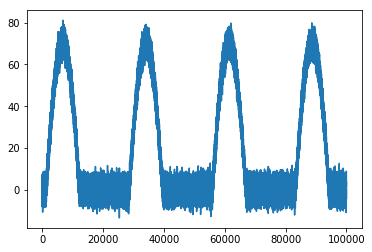

In [75]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(waveform)

GPU allocation, not complited?

In [81]:
pulse_device = cuda.to_device(pulses)

In [90]:
out_device = cuda.device_array(shape=(n,), dtype=np.float32)

In [87]:
add_ufunc(x_device, y_device, out=out_device)

In [88]:
out_host = out_device.copy_to_host()

In [89]:
out_host[0:10]

array([ 0.,  3.,  6.,  9., 12., 15., 18., 21., 24., 27.], dtype=float32)

Full GPU allocation

In [94]:
pulse_device = cuda.device_array(shape=(n,), dtype=np.float32)
t_device = cuda.to_device(t)
period_device = cuda.to_device(period)
amp_device = cuda.to_device(100.0)
make_pulses(t_device, period_device, amp_device, out=pulse_device) # Change types of arguments according to function

TypeError: No matching version.  GPU ufunc requires array arguments to have the exact types.  This behaves like regular ufunc with casting='no'.